# 問題
![](img/1D-PML.png)

# 各種パラメータの設定

In [101]:
import numpy as np

order = 4  # PMLの次数
lpml  = 8  # PMLの層数
rmax  = -120 # 要求精度[dB]

nz0   = 1000         # 解析領域の分割数 
nstep = 2000         # 計算領域の分割数
nz    = nz0 + 2*lpml # 時間ステップ総数

ex = np.zeros(nz) # 電界
hy = np.zeros(nz) # 磁界

ex_t = np.zeros(nstep) # 時間応答

# 係数
ae = np.zeros(nz)
be = np.zeros(nz)
am = np.zeros(nz)
bm = np.zeros(nz)

# 媒質定数
epsd  = np.ones(nz+1)
sgmd  = np.zeros(nz+1)
mud   = np.ones(nz+1)
msgmd = np.zeros(nz+1)

# 定数
eps0 = 8.8541878e-12
mu0  = 1.2566371e-6
z0   = 376.73031
c    = 2.9979246e8

d    = 0.1  # 誘電体層の厚さ[m]
nd   = 50   # 誘電体層の分割数
dz   = d/nd # セルサイズ
epsr = 3.0  # 誘電体層の比誘電率
kd   = nz/2 # 誘電体層の左側の位置

# 入射パルス

In [102]:
def input_pulse(z, tm):
    zp = (lpml+100)*dz # パルスの中心位置
    a = 20 * dz        # パルス幅
    return np.exp(-((z - zp - c*tm)/a)**2)

# 初期化

In [103]:
for k in range(-1,nz-2):
    if kd < k and k <= kd+nd: # 真空領域
        epsd[k]  = epsr
        sgmd[k]  = 0.0
        mud[k]   = 1.0
        msgmd[k] = 0.0
    else : # 誘電体層
        epsd[k]  = 1.0
        sgmd[k]  = 0.0
        mud[k]   = 1.0
        msgmd[k] = 0.0

dt = 0.9*dz/c # 時間ステップ
for k in range(0, nz-1):
    # セル表面の媒質定数は両面の平均
    eps = 0.5 * (epsd[k] + epsd[k-1])*eps0
    sgm = 0.5 * (sgmd[k] + sgmd[k-1])

    b  = dt/eps
    a0 = 0.5 * sgm * b
    ae[k] = (1 - a0)/(1 + a0)
    be[k] = b/(1 + a0)/dz

    mu = mud[k] * mu0
    msgm = msgmd[k]
    b = dt/mu
    a0 = 0.5*msgm*b
    am[k] = (1 - a0)/(1 + a0)
    bm[k] = b/(1 + a0)/dz

# 電界の初期化
for k in range(nz):
    z = k*dz
    ex[k] = input_pulse(z, 0)

# 磁界の初期化
for k in range(nz):
    z = (k + 0.5)*dz
    hy[k] = input_pulse(z, 0.5*dt) / z0

電磁界の可視化

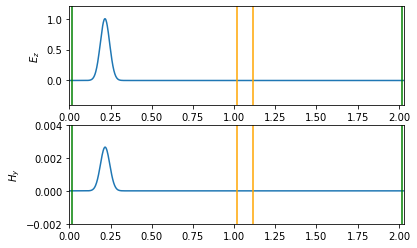

In [104]:
%rm result/*.png

import matplotlib.pylab as plt

def plot(t, show=False):
    plt.figure(figsize=(6,4))
    plt.subplot(211)
    z = np.linspace(0, nz*dz, nz)
    plt.plot(z, ex)
    plt.plot([dz*kd,dz*kd]    , [-1.2,1.2], color="orange")
    plt.plot([dz*kd+d,dz*kd+d], [-1.2,1.2], color="orange")
    plt.plot([lpml*dz,lpml*dz], [-1.2,1.2], color="green")
    plt.plot([(nz-lpml)*dz,(nz-lpml)*dz], [-1.2,1.2], color="green")
    plt.ylabel(r'$E_z$')
    plt.xlim(0, dz*nz)
    plt.ylim(-0.4, 1.2)

    plt.subplot(212)
    z = np.linspace(dz/2, nz*dz, nz)
    plt.plot(z, hy)
    plt.plot([dz*kd,dz*kd]    , [-0.02,0.02], color="orange")
    plt.plot([dz*kd+d,dz*kd+d], [-0.02,0.02], color="orange")
    plt.plot([lpml*dz,lpml*dz], [-0.02,0.02], color="green")
    plt.plot([(nz-lpml)*dz,(nz-lpml)*dz], [-0.02,0.02], color="green")
    plt.ylabel(r'$H_y$')
    plt.xlim(0, dz*nz)
    plt.ylim(-0.002, 0.004)

    plt.savefig("result/{}.png".format(t),  facecolor="white", edgecolor="coral")
    if show:
        plt.show()
    plt.close()

plot(1, True)

# 電磁界の計算とPML吸収境界

In [105]:
def e_cal():
    for k in range(1, nz-1):
        ex[k] = ae[k] * ex[k] - be[k] * ( hy[k] - hy[k-1] )

def h_cal():
    for k in range(0, nz-1):
        hy[k] = am[k] * hy[k] - bm[k] * ( ex[k+1] - ex[k] )

def pmlcoef():
    copml = -1.5280063e-4

    epslr = epsd[lpml+1]
    epsl  = epslr*eps0
    epsrr = epsd[nz-lpml-1]
    epsr  = epsrr*eps0
    mul = mud[lpml+1]*mu0
    mur = mud[nz-lpml-1] * mu0

    # 真空に対するsigma_maxと係数
    smaxOe = copml * rmax * (order+1) / (lpml*dz)

    # 左側のPML
    for k in range(0, lpml-1):
        sgme = ((lpml-k)/lpml)**order * smaxOe * epslr
        sgmm = ((lpml-k-0.5)/lpml)**order *smaxOe * epslr
        
        a0 = 0.5*sgme*dt/epsl
        ae[k] = (1 - a0)/(1 + a0)
        be[k] = dt/epsl/(1 + a0)/dz

        a0 = 0.5*sgmm*dt*epsl
        am[k] = (1 - a0)/(1 + a0)
        bm[k] = dt/mul/(1 + a0)/dz

    # 右側のPML
    for k in range(nz-lpml, nz-1):
        sgme = ((k-nz+lpml)/lpml)**order * smaxOe * epsrr
        sgmm = ((k-nz+lpml+0.5)/lpml)**order * smaxOe * epsrr

        a0 = 0.5*sgme*dt/epsr
        ae[k] = (1 - a0)/(1 + a0)
        be[k] = dt/epsr/(1 + a0)/dz

        a0 = 0.5*sgmm*dt/epsr
        am[k] = (1 - a0)/(1 + a0)
        bm[k] = dt/mur/(1 + a0)/dz


# FDTDの計算

In [106]:
from tqdm import tqdm

pmlcoef()
t = dt
for n in tqdm(range(1, nstep)):
    e_cal()
    t += dt/2

    ex_t[n] = ex[int(nz/2)]

    h_cal()
    t += dt/2

    if n%5 == 0:
        plot(n)

100%|██████████| 1999/1999 [00:51<00:00, 38.79it/s]


In [107]:
%pip install Pillow
%pip install natsort

from PIL import Image
import glob
from natsort import natsorted


files = natsorted(sorted(glob.glob('result/*.png')))

images = list(map(lambda file: Image.open(file), files))

images[0].save('img/1d-pml.gif', save_all=True, optimize=False, append_images=images[1:], duration=1, loop=0)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


電界の時間応答

/tmp/ipykernel_35963/844213371.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(t, 10*np.log(ex_t) , label=r"z = {:.4g} m".format((nz/2)*dz))
/tmp/ipykernel_35963/844213371.py:3: RuntimeWarning: invalid value encountered in log
  plt.plot(t, 10*np.log(ex_t) , label=r"z = {:.4g} m".format((nz/2)*dz))


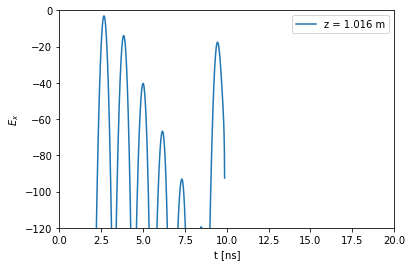

In [108]:
t = np.linspace(0, nstep*dt * 1e9, nstep)

plt.plot(t, 10*np.log(ex_t) , label=r"z = {:.4g} m".format((nz/2)*dz))
plt.xlim(0, 20)
plt.ylim(rmax, 0)
plt.xlabel("t [ns]")
plt.ylabel(r"$E_x$")
plt.legend()

plt.savefig("img/1D-time-domain.png", facecolor="white", edgecolor="coral")
plt.show()